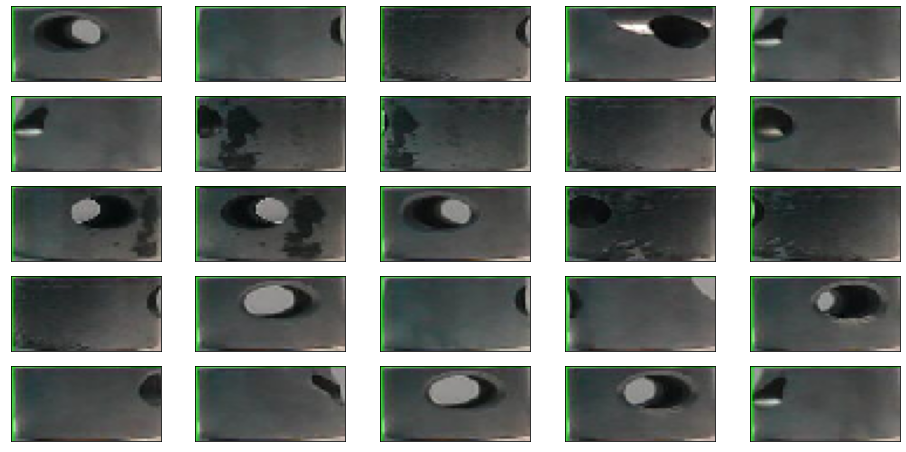

In [55]:
# This function plots images from a folder. 

import glob
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import random

def plot_images(source_path):
    files=[]
    classes = glob.glob(source_path + '/*')
    for class_path in classes:
        files.extend([f for f in glob.glob(class_path + "/*", recursive=True)])
    random.shuffle(files)
    plt.figure(figsize=(16, 8))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        img = image.load_img(files[i], target_size=(32, 64))
        plt.imshow(img, cmap=plt.cm.binary)
    plt.show()
    
plot_images('data/train_data')

In [56]:
IMG_HEIGHT = 80
IMG_WIDTH = 80

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(rescale=1./255)
train_data_gen = train_image_generator.flow_from_directory(directory='data/train_data',
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

Found 228 images belonging to 3 classes.


In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model = Sequential([
    Dense(24, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    Flatten(),
    Dense(3),
    Dense(3)
])

In [58]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 80, 80, 24)        96        
                                                                 
 flatten_7 (Flatten)         (None, 153600)            0         
                                                                 
 dense_22 (Dense)            (None, 3)                 460803    
                                                                 
 dense_23 (Dense)            (None, 3)                 12        
                                                                 
Total params: 460,911
Trainable params: 460,911
Non-trainable params: 0
_________________________________________________________________


In [59]:
history = model.fit_generator(train_data_gen, epochs=25)

Epoch 1/25


C:\Users\ANSni\AppData\Local\Temp/ipykernel_25992/1551119544.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data_gen, epochs=25)


8/8 [==============================] - 0s 19ms/step - loss: 2.2241 - accuracy: 0.3640
Epoch 2/25
8/8 [==============================] - 0s 19ms/step - loss: 0.7275 - accuracy: 0.6974
Epoch 3/25
8/8 [==============================] - 0s 21ms/step - loss: 0.5321 - accuracy: 0.8289
Epoch 4/25
8/8 [==============================] - 0s 21ms/step - loss: 0.4121 - accuracy: 0.8596
Epoch 5/25
8/8 [==============================] - 0s 19ms/step - loss: 0.2890 - accuracy: 0.9474
Epoch 6/25
8/8 [==============================] - 0s 20ms/step - loss: 0.1807 - accuracy: 0.9825
Epoch 7/25
8/8 [==============================] - 0s 18ms/step - loss: 0.1633 - accuracy: 0.9868
Epoch 8/25
8/8 [==============================] - 0s 18ms/step - loss: 0.1114 - accuracy: 0.9956
Epoch 9/25
8/8 [==============================] - 0s 21ms/step - loss: 0.0660 - accuracy: 1.0000
Epoch 10/25
8/8 [==============================] - 0s 18ms/step - loss: 0.0506 - accuracy: 1.0000
Epoch 11/25
8/8 [=======================

In [60]:
test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(directory='data/test_data',
                                                         shuffle=False,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         class_mode='categorical')

loss, accuracy = model.evaluate(test_data_gen)
print("loss: %f, accuracy: %f" % (loss, accuracy))

Found 57 images belonging to 3 classes.
2/2 [==============================] - 0s 10ms/step - loss: 0.0936 - accuracy: 1.0000
loss: 0.093558, accuracy: 1.000000


In [61]:
import pickle
file_pickle = open('model.pkl', 'wb')
pickle.dump(model, file_pickle)
file_pickle.close()

INFO:tensorflow:Assets written to: ram://a444fd20-9770-49f4-b827-d7c918cbdc93/assets


In [62]:
import tensorflow as tf
import numpy as np

new_model_file = open('model.pkl', 'rb')
model = pickle.load(new_model_file)
model = tf.keras.Sequential([tf.keras.layers.Rescaling(scale=1./255), model, tf.keras.layers.ReLU()])

label = {0: 'Defect 1', 1: 'Defect 2', 2: 'Normal'}

FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://206f56c6-1bed-48b0-979c-6793d6a55530/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [ ]:
path = './data/test_data/defect_2/defect2_76.jpeg'
img = tf.keras.preprocessing.image.load_img(path, target_size=(80,80))
inputarr = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.array([inputarr])


predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(label[np.argmax(score)], 100 * np.max(score))
)

print(score)

In [ ]:
import keras

img = keras.preprocessing.image.load_img('./data/test_data/defect_1/defect_87.jpeg', target_size=(80,80))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(label[np.argmax(score)], 100 * np.max(score))
)

print(score)

In [ ]:
img = keras.preprocessing.image.load_img('./data/test_data/normal/normal_97.jpeg', target_size=(80,80))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(label[np.argmax(score)], 100 * np.max(score))
)

print(score)